In [1]:
%matplotlib inline
import numpy as N
import scipy.sparse as sp
from scipy.integrate import ode
import matplotlib.pyplot as plt

/home/marek/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def species(soubor):
        species = file(soubor,"r")
        conc = []  # speci
        pomoc = {}
        index = 0
        for line in species:
            try:     
                name, init_conc = line.split()
                pomoc[name] = index
                conc.append(float(init_conc))  
                index += 1
            except: continue   
        species.close()
        conc = N.array(conc)
        
        return conc, pomoc        

In [3]:
def reactions(soubor, pomoc):
    reaction = file(soubor,"r")
    index = 0
    k_c = []
    REACT = []
    PROD = []
    for line in reaction:
        try:
            rovnice = line.split()
            k_c.append(float(rovnice[0]))
            rozdel = rovnice.index("=>")
            pozn = rovnice.index("//")
            
            reactant=(rovnice[1:rozdel])
            product=(rovnice[rozdel+1:pozn])
            REACTp = N.zeros(len(pomoc),int)
            PRODp = N.zeros(len(pomoc),int)
        except: continue
        for i in range(len(reactant)):
            if (REACTp[pomoc[reactant[i]]] == 0):      # - zbytecna podminka .. ?
                j = reactant.count(reactant[i])
                REACTp[pomoc[reactant[i]]] = j
        REACT.append(REACTp)
        for i in range(len(product)):
            if (PRODp[pomoc[product[i]]] == 0):      # - zbytecna podminka .. ?
                j = product.count(product[i])
                PRODp[pomoc[product[i]]] = j
        PROD.append(PRODp)
        index += 1
    
    reaction.close()
    k_c = N.array(k_c)
    REACT = N.array(REACT)
    PROD = N.array(PROD)
    Z = PROD - REACT
    REACT = sp.csr_matrix(REACT)
    
    POSITIV =  N.zeros((len(k_c),len(pomoc)), dtype = int)     # pro testovani
    NEGATIV =  N.zeros((len(k_c),len(pomoc)), dtype = int)     # pro testovani

    for i in range(len(k_c)):
        for j in range(len(pomoc)):
            if Z[i][j] < 0: 
                NEGATIV[i][j] = Z[i][j]
            else: POSITIV[i][j] = Z[i][j]
                    
    NEGATIV = N.transpose(NEGATIV)
    NEGATIV = sp.csr_matrix(NEGATIV)
    POSITIV = N.transpose(POSITIV)
    POSITIV = sp.csr_matrix(POSITIV)

    Z = N.transpose(Z)      #/ csr_matrix.getH(Z)
    Z = sp.csr_matrix(Z)                    
    
    return k_c, REACT, Z, NEGATIV, POSITIV

In [4]:
def difuze(rate_elast, con): # He + H
    l = (15e-3)
    l = l/2.405
    l = l**2
    nu = rate_elast * con 
    Di = k_b*Tn / (m_H*nu)
    tau = l/Di

    return tau

In [22]:
def create_ODE(t, concentration, k_c, Z, REACT, POSITIV, NEGATIV, pomoc):
    # sestaveni rovnice pro resic lsoda; nevyzaduje vypocet jakobianu 
   
    k_c[0] = difuze(elastic_He_H, concentration[pomoc["He"]])    
    
    f = N.log(concentration)
    f = REACT * f
    f = N.exp(f)
    f = N.multiply(f,k_c)
    global vypis
    global ind_vyvoj
    global opak
    
    if (ind_vyvoj >= vypis and ind_vyvoj <=1000):
        print "vypis", vypis
        print "vyvoj", ind_vyvoj
        vypis += 0.001 * int(time/time_step)

                    # ind_vyvoj, podminka pro tisk hodnot
        print POSITIV * f
        print
        print NEGATIV * f
        print
        print
    if (t >= time):  
        if (ind_vyvoj != opak):
            print "vyvoj", ind_vyvoj
            print POSITIV * f
            print
            print NEGATIV * f
            print
            opak = ind_vyvoj
     
        
    f = Z * f        
    return f

In [23]:
def solve_ODE(file_species, file_reactions, t1, dt):

    t0 = 0
    y0, pomoc = species(file_species)
    k_c, REACT, Z, NEGATIV, POSITIV = reactions(file_reactions, pomoc)

    vyvoj = [y0]
    cas = [0]   
    global ind_vyvoj
    
    r = ode(create_ODE).set_integrator('lsoda')
    r.set_initial_value(y0, t0).set_f_params(k_c, Z, REACT, POSITIV, NEGATIV, pomoc)

    while r.successful() and r.t < t1:
        r.integrate(r.t+dt)

        ind_vyvoj += 1
        cas.append(r.t)
        vyvoj.append(r.y)

    vyvoj = N.array(vyvoj)
    cas = N.array(cas)

    return r, pomoc, cas, vyvoj

In [24]:
file_species = "data/speci.txt"
file_reactions = "data/reakce.txt"
time = 60e-3
time_step = time/10e3
vypis = 0 #.1 * int(time / time_step)
ind_vyvoj = 0
opak = ind_vyvoj

elastic_He_H = 1.26076522957e-12
k_b = 1.38e-23
Tn = 77
m_H = 1.00794 * 1.667e-27

concentrations, pomoc, cas, vyvoj = solve_ODE(file_species, file_reactions, time, time_step)
print pomoc

/home/marek/anaconda2/lib/python2.7/site-packages/ipykernel/__main__.py:6: RuntimeWarning: divide by zero encountered in log


vypis 0
vyvoj 0
[  1.35367541e+14   0.00000000e+00   3.56621303e+12   5.33749853e+14
   7.53161373e+10   0.00000000e+00   1.21445328e+11   0.00000000e+00
   1.31938901e+14   0.00000000e+00   0.00000000e+00   3.75979893e+10
   0.00000000e+00   0.00000000e+00   0.00000000e+00   1.15435688e+14]

[ -2.01283349e+12  -2.67326707e+14   0.00000000e+00   0.00000000e+00
   0.00000000e+00  -2.14187512e+12   0.00000000e+00  -2.47374590e+14
   0.00000000e+00   0.00000000e+00  -3.75979893e+10   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00]


vypis 10.0
vyvoj 10
[  6.61545726e+14   1.71421573e+11   2.07121141e+14   1.98412038e+15
   1.75075179e+12   2.30345528e+14   3.98278064e+11   2.24361458e+14
   4.32856408e+14   5.21158948e+06   2.75814438e+12   2.83050654e+12
   2.84471406e+12   3.52111702e+14   2.29155481e+13   3.76417432e+14]

[ -1.06655866e+13  -1.32299070e+15  -2.04778681e+14  -7.21182027e+09
  -1.47073807e+12  -1.17122718e+13  -1.68060946e+11  -1.1596

In [14]:
for i in pomoc.keys():
    print i, ": \t  ", concentrations.y[pomoc[i]]

e- : 	   6.42465887881e+17
He2+ : 	   2.9852848521e+17
He(1s2s) : 	   11445307.2874
Ar+ : 	   580412976371.0
H2 : 	   4.04454705416
H3+ : 	   0.000828391167171
H- : 	   369594.503129
H2wall : 	   804875.795185
H+ : 	   2.7620030466e+12
HeH+ : 	   1.87873592177e+15
Ar : 	   2.22487678719e-05
H2+ : 	   4.31150036031
H : 	   171486983704.0
He+ : 	   3.42054963746e+17
ArH+ : 	   360587023629.0
He : 	   9.32989988442e+12


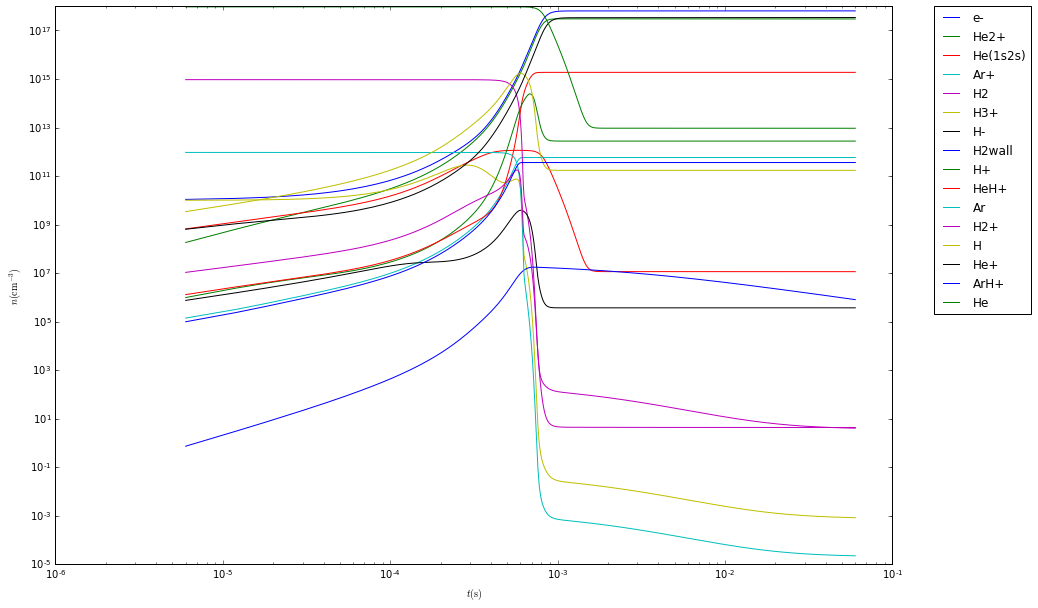

In [15]:
plt.figure(figsize=(15, 10))
for i in pomoc.keys():
    plt.loglog(cas[:], vyvoj[:,pomoc[i]], label = i)

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.xlabel(r"$t (\rm s)$")
plt.ylabel(r"$n (\rm cm^{-3})$")